# Building a damage assessment system for aerospace industry 

**Context** 

We aim to build a machine learning system that will determine for a given damage on the aircraft if this damage is allowable or not : 

- Allowable damage (negative output) means that aircraft can fly without any danger. An inspection program is though recommended 
- Not allowable damage (positive output) means that aircraft should be kept on ground for maintenance

**Summary**

We assume we have the necessary data. We explore it with Pandas, Numpy 
and Pyplot. Make predictions with appropriate machine learning algorithms such as linearSVV or DecisionTree. Calculate and compare F1 scores

# Project  
## Import libraries

In [17]:
# author: houcem
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

In [11]:
#Loard the data
data = pd.read_csv('/home/houcem/Bureau/Training_data1.csv')
#drop the index column 
data = data.drop("Unnamed: 0",axis = 1)
data.head()
print("Damage data matrix shape is " , data.shape)
print("Its type is :  ",  type(data))

Damage data matrix shape is  (1000, 10)
Its type is :   <class 'pandas.core.frame.DataFrame'>


In [12]:
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,y
0,False,True,False,0.24,1.17,10.76,232.16,69.30,334.05,0
1,False,True,False,0.23,1.16,11.17,144.87,107.79,179.21,0
2,False,True,False,0.16,1.23,6.96,94.04,65.41,97.57,0
3,False,False,False,0.71,1.51,42.00,422.47,244.88,423.47,1
4,False,True,False,0.14,1.72,5.79,92.03,64.42,93.43,0


**Data** 

We are provided with a data set of 1000 damages. Each damage is described with 9 features. We can notice that x1,x2,x3 are boolean feature and that x3..x9 are numerical features. 

**Features and Labels **

**Features**

**(x1,x2,x3) : booleans** 

We know that x1,x2 and x3 are answers to some basic questions about the damage properties : 
- Is there any other damage in the area ? 
- Is there more than one different damage type in the area ? 
- Is the damage close to riveted areas ?

**(x4,x5,x6,x7,x8,x9) : numerical** 

These features are related to geometric data. They describe the distances, thicknesses and diameters of the damage. 
For example :  x5 describes the nominal thickness of the damaged panel  

**Label**

**y : 0 or 1 **

A damage labeled 0 is a negative damage. That means that it doesn't represent a major danger. Hence, the airplane can continue to fly. 
A damage labeled 1 is positive damge. That means that it requires to stop the airplane from flying and send it to a maintenance center.

In [13]:
#show an overall descrption of numerical values 
data.describe()

,x4,x5,x6,x7,x8,x9,y
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.33014,1.434470,18.851180,260.368290,76.672000,320.792680,0.250000
std,0.32173,0.330876,23.829437,156.693256,81.221931,152.445572,0.433229
min,0.10000,1.000000,4.010000,1.980000,0.000000,3.800000,0.000000
25%,0.14000,1.140000,6.440000,113.570000,0.000000,183.005000,0.000000
50%,0.20000,1.270000,9.610000,251.085000,64.175000,340.975000,0.000000
75%,0.30250,1.730000,14.805000,430.910000,105.957500,484.952500,0.250000
max,1.59000,2.000000,123.410000,499.770000,495.920000,500.770000,1.000000


## Quick insights 

- y.mean() = 0.25 , That means that 25% of the data is positive. We clearly have a problem of unbalanced data. Choosing F1_score as a performance metric is a best practice 

- at least 25 % of x8 values are equal to 0. 



In [15]:
#preprocess data 
X = data.drop("y", axis = 1)
y = data.y
# data set to use 
print(" the shape of X is " , X.shape)
print(" the shape of y is ", y.shape)
print(" Positive cases represent {}% of the data".format(100*y.mean()))

 the shape of X is  (1000, 9)
 the shape of y is  (1000,)
 Positive cases represent 25.0% of the data


/home/houcem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/home/houcem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67e5dcd320>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f67e2cad3c8>]], dtype=object)

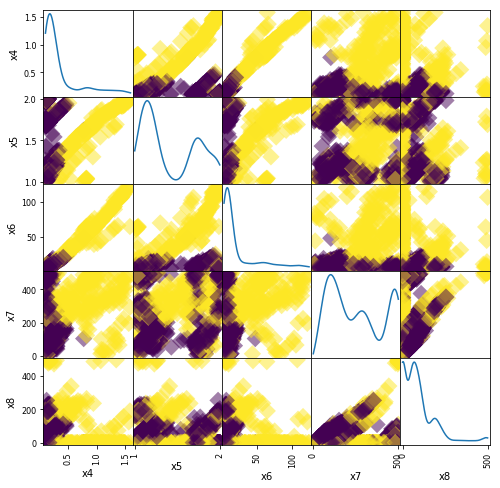

In [18]:
# Descriptive statistics 
pd.scatter_matrix(X.ix[:,3:(-1)],c=y, figsize= [8, 8], s= 150 , marker = 'D', diagonal = "kde")

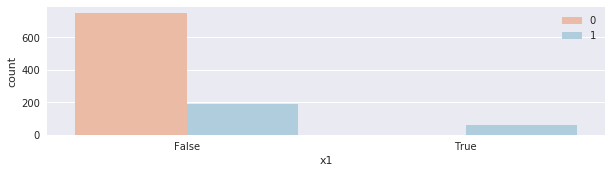

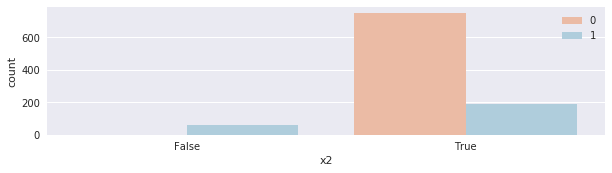

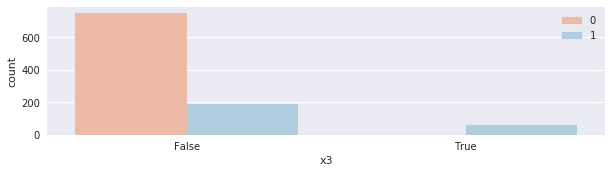

In [30]:
import seaborn as sns 
figsz =[10,8]
features = ["x1","x2","x3"] 
for i,name in enumerate(features):
    sns.set(style="darkgrid")
    plt.figure(figsize= figsz) 
    plt.subplot(3, 1, i+1)
    ax = sns.countplot(x= name, data = X ,hue=y, palette = "RdBu")
    # Add legend to plot
    plt.legend()
    plt.show()

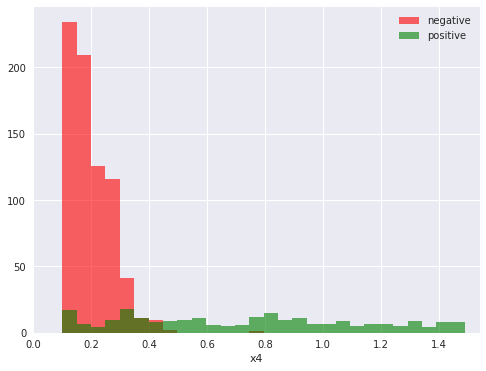

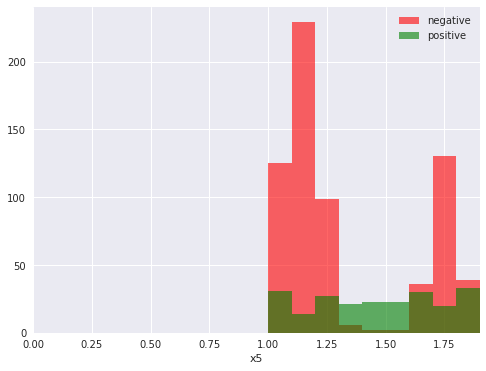

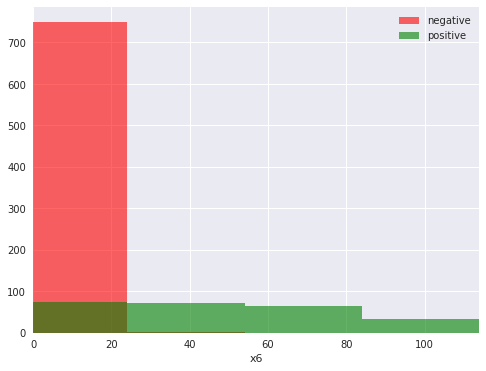

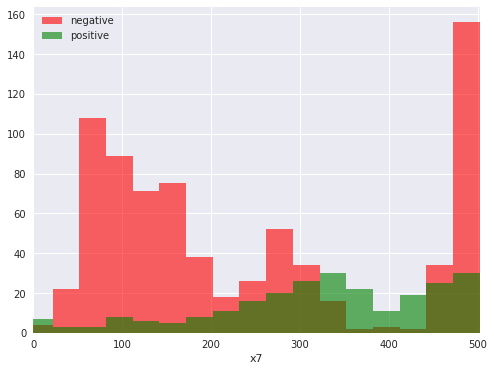

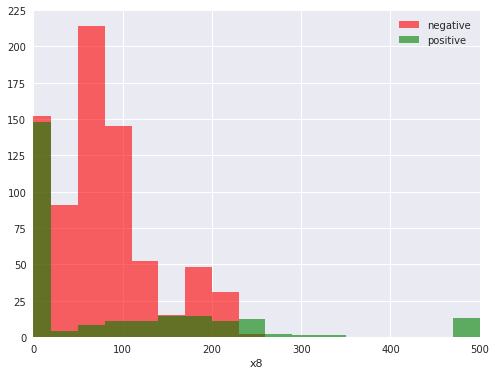

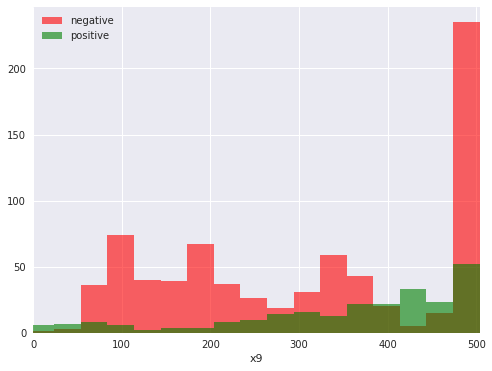

In [31]:
def plot_feature(data, outcomes, key):
    # Merge data and outcomes into single dataframe
    all_data = pd.concat([data, outcomes.to_frame()], axis = 1)
    # Create outcomes DataFrame
    all_data = all_data[[key, 'y']]
    # Create plotting figure
    plt.figure(figsize=(8,6))
    # Remove NaN values from Age data
    all_data = all_data[~np.isnan(all_data[key])]
    # Divide the range of data into bins and count survival rates
    min_value = all_data[key].min()
    max_value = all_data[key].max()
    value_range = max_value - min_value
    if key in ["x6", "x7", "x8", "x9"]:
        bins = np.arange(min_value - 10 , max_value + 10, 30)
    else:
        if key == "x5": 
            bins = np.arange(1, 2, 0.1)
        else:
            bins = np.arange(min_value, max_value, (value_range/30))
    # Overlay each bin's survival rates
    neg_vals = all_data[all_data['y'] == 0][key].reset_index(drop = True)
    pos_vals = all_data[all_data['y'] == 1][key].reset_index(drop = True)
    plt.hist(neg_vals, bins = bins, alpha = 0.6, color = 'red', label = 'negative')
    plt.hist(pos_vals, bins = bins, alpha = 0.6,color = 'green', label = 'positive')
    plt.xlabel(key)
    # Add legend to plot
    plt.xlim(0, bins.max())
    plt.legend(framealpha = 0.8)

features = ["x4","x5","x6","x7","x8","x9"] 
for i in features:
    plot_feature(X, y, i)

# Preprocess categorical features 
We should replace boolean features (or categorical) with numerical features. 

In [41]:
for i in ["x1","x2","x3"]:
    X[i] = X[i].replace(to_replace = [True,False], value = [1,0])
X.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,0,1,0,0.24,1.17,10.76,232.16,69.30,334.05
1,0,1,0,0.23,1.16,11.17,144.87,107.79,179.21
2,0,1,0,0.16,1.23,6.96,94.04,65.41,97.57
3,0,0,0,0.71,1.51,42.00,422.47,244.88,423.47
4,0,1,0,0.14,1.72,5.79,92.03,64.42,93.43


# Train test split 

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1 , random_state = 42, 
                                                    stratify = y) 

In [45]:
# check the split 
print ("Training set has samples ", X_train.shape[0] ) 
print ("Testing set has samples ", X_test.shape[0] ) 
print ("Positive damages proportion in training set is ", y_train.mean())
print ("Positive damages proportion in testing set is ", y_test.mean())

Training set has samples  900
Testing set has samples  100
Positive damages proportion in training set is  0.25
Positive damages proportion in testing set is  0.25


# Some useful functions for classification 

- train_classifier - takes as input a classifier and training data and fits the classifier to the data.

- predict_labels - takes as input a fit classifier, features, and a target labeling and makes predictions using the F1 score.

- train_predict - takes as input a classifier, and the training and testing data, and performs train_clasifier and predict_labels.
This function will report the F1 score for both the training and testing data separately.

In [46]:
# define useful functions 
from time import time 
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''

    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()

    # Print the results
    print("Trained model in " + str(end - start) +  " seconds" )


def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''

    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()

    # Print and return results
    print("Made predictions in {:.4f} seconds.".format(end - start))
    return f1_score(target.values, y_pred, pos_label = 1 )


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''

    # Indicate the classifier and the training set size
    print("")
    print("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))

    # Train the classifier
    train_classifier(clf, X_train, y_train)

    # Print the results of prediction for both training and testing
    print("F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train)))
    print("F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test)))


# Algorithms 

In [48]:
# try different algorithms  
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier 
from sklearn.tree import DecisionTreeClassifier

In [54]:
# Initialize models
clf_A = GaussianNB()
clf_B = LogisticRegression(random_state=42)
clf_C = LinearSVC(random_state=42)
clf_D = MLPClassifier(random_state=42)
clf_E = DecisionTreeClassifier(random_state = 42) 

In [55]:
#the training data size is 900. Let's increase the training data size gradually 
n_training_examples = [300, 600, 900]

for clf in [clf_A, clf_B, clf_C, clf_D, clf_E]:
    print("\n{}: \n".format(clf.__class__.__name__))
    for n in n_training_examples:
        train_predict(clf, X_train[:n], y_train[:n], X_test, y_test)



GaussianNB: 


Training a GaussianNB using a training set size of 300. . .
Trained model in 0.004349708557128906 seconds
Made predictions in 0.0014 seconds.
F1 score for training set: 0.9333.
Made predictions in 0.0011 seconds.
F1 score for test set: 0.8936.

Training a GaussianNB using a training set size of 600. . .
Trained model in 0.0025091171264648438 seconds
Made predictions in 0.0014 seconds.
F1 score for training set: 0.9286.
Made predictions in 0.0020 seconds.
F1 score for test set: 0.8936.

Training a GaussianNB using a training set size of 900. . .
Trained model in 0.003633737564086914 seconds
Made predictions in 0.0012 seconds.
F1 score for training set: 0.9387.
Made predictions in 0.0071 seconds.
F1 score for test set: 0.8936.

LogisticRegression: 


Training a LogisticRegression using a training set size of 300. . .
Trained model in 0.006915092468261719 seconds
Made predictions in 0.0010 seconds.
F1 score for training set: 0.9333.
Made predictions in 0.0009 seconds.
F1 s

# Tune a decision tree model

In [60]:
#model tuning in decision tree 
        
# Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.cross_validation import StratifiedShuffleSplit


# Create the parameters list you wish to tune
criterion = ['gini','entropy']
max_depth = [3,5,6,8,10,12,20]
min_samples_leaf = [3,4,5,10,50]
param_grid = dict(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        

In [61]:
# Initialize the classifier
clf = DecisionTreeClassifier(random_state=42)


# Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label= 1 )

# Stratified Shuffle Split
ssscv = StratifiedShuffleSplit(y_train, n_iter=10, test_size=0.1)

#Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, param_grid, cv=ssscv, scoring=f1_scorer)

#Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

In [64]:
# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print("Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train)))
print("Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test)))

print( "Here are best found hyperparameters of the best decision tree model:")
print(" criterion =" , clf.get_params()['criterion'])
print(" max_depth =" , clf.get_params()['max_depth'])
print(" min_samples_leaf = ", clf.get_params()['min_samples_leaf'])

Made predictions in 0.0011 seconds.
Tuned model has a training F1 score of 0.9867.
Made predictions in 0.0006 seconds.
Tuned model has a testing F1 score of 0.9412.
Here are best found hyperparameters of the best decision tree model:
 criterion = gini
 max_depth = 10
 min_samples_leaf =  3
